In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 3,  4,  6,  9,  8,  7,  0,  2, 10]), tensor([1, 5]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
import torch.nn as nn 

linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[2.1713],
        [1.8056]], grad_fn=<AddmmBackward0>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[0.5223]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([-0.7486], requires_grad=True)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([-0.2262], grad_fn=<AddBackward0>)

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.2262],
        [-0.2262],
        [-0.2262],
        [-0.2262],
        [-0.2262],
        [-0.2262],
        [-0.2262],
        [-0.2262],
        [-0.2262],
        [-0.2262]], grad_fn=<AddmmBackward0>)

In [10]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

In [11]:
linear_model.parameters()

<generator object Module.parameters at 0x7f7ad17cd120>

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.4891]], requires_grad=True),
 Parameter containing:
 tensor([0.3140], requires_grad=True)]

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [14]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 298.8074, Validation loss 216.9123
Epoch 1000, Training loss 3.8092, Validation loss 1.6065
Epoch 2000, Training loss 3.2966, Validation loss 1.3581
Epoch 3000, Training loss 3.2878, Validation loss 1.3321

Parameter containing:
tensor([[5.3322]], requires_grad=True)
Parameter containing:
tensor([-17.1569], requires_grad=True)


In [15]:
seq_model = nn.Sequential(
            nn.Linear(1, 13),
            nn.Tanh(),
            nn.Linear(13, 1))

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [16]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [17]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [18]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [19]:
for namae, param in seq_model.named_parameters():
    print(name, param.shape)

2.bias torch.Size([8, 1])
2.bias torch.Size([8])
2.bias torch.Size([1, 8])
2.bias torch.Size([1])


In [20]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.1605], requires_grad=True)

In [21]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 189.6293, Validation loss 119.2374
Epoch 1000, Training loss 4.9396, Validation loss 1.3526
Epoch 2000, Training loss 3.6068, Validation loss 8.2863
Epoch 3000, Training loss 2.1892, Validation loss 7.3273
Epoch 4000, Training loss 1.8075, Validation loss 6.8133
Epoch 5000, Training loss 1.6905, Validation loss 6.6328
output tensor([[11.7180],
        [ 7.3313]], grad_fn=<AddmmBackward0>)
answer tensor([[14.],
        [ 8.]])
hidden tensor([[-1.4629e+01],
        [ 9.6542e-01],
        [-1.4272e+00],
        [ 1.7484e-01],
        [-2.0544e+00],
        [ 1.6996e+01],
        [-1.8324e+01],
        [-5.1332e-03]])


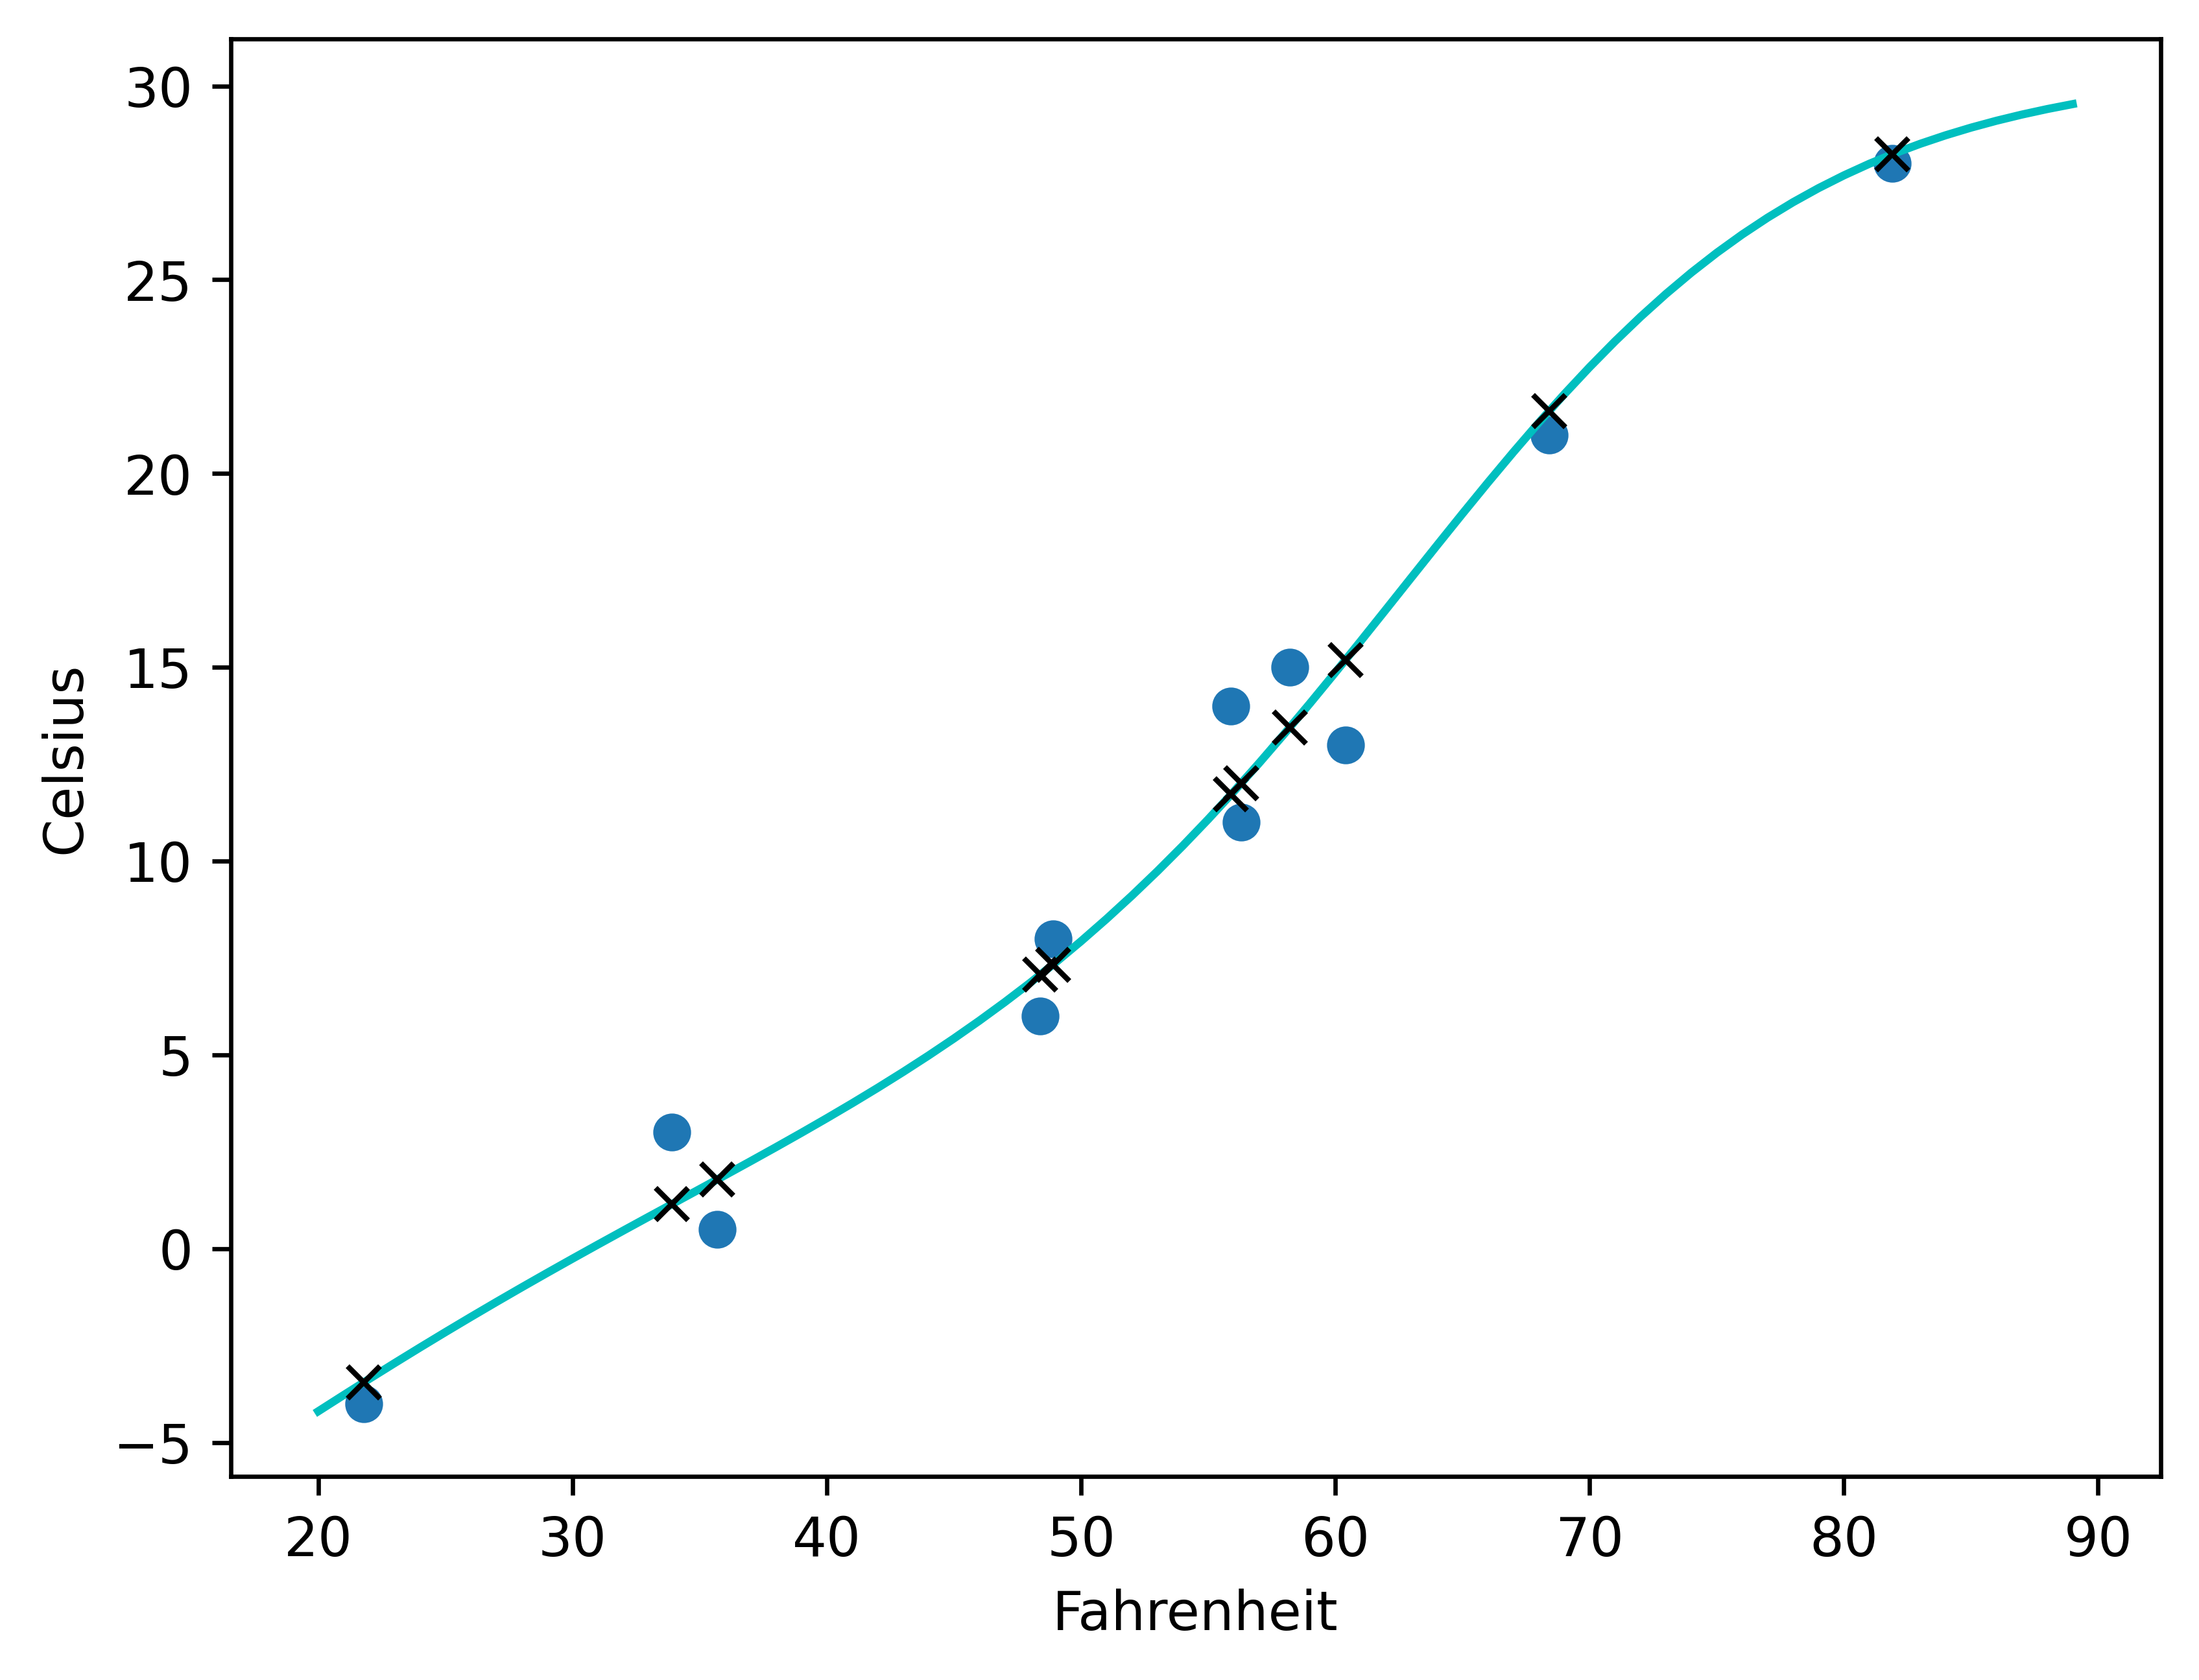

In [22]:
from matplotlib import pyplot as plt 

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)

plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')